In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
date_str = str(last_date).replace(',','').replace('(','').replace(')','').replace("'",'')
date = datetime.strptime(date_str, "%Y-%m-%d")
query_date = date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_data = pd.DataFrame(results, columns=['date','prcp'])
precip_data["date"] = precip_data["date"].astype('datetime64[D]').dt.date
precip_data = precip_data.set_index('date')

# Sort the dataframe by date
precip_data = precip_data.sort_values(by=['date'])
precip_data

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


                prcp
date                
2016-08-24  1.555000
2016-08-25  0.077143
2016-08-26  0.016667
2016-08-27  0.064000
2016-08-28  0.516667
...              ...
2017-08-19  0.030000
2017-08-20  0.005000
2017-08-21  0.193333
2017-08-22  0.166667
2017-08-23  0.132500

[365 rows x 1 columns]


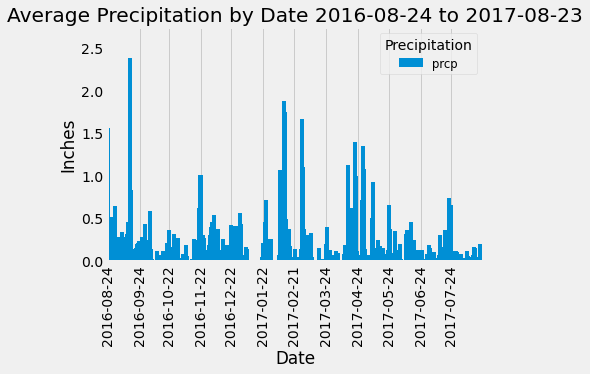

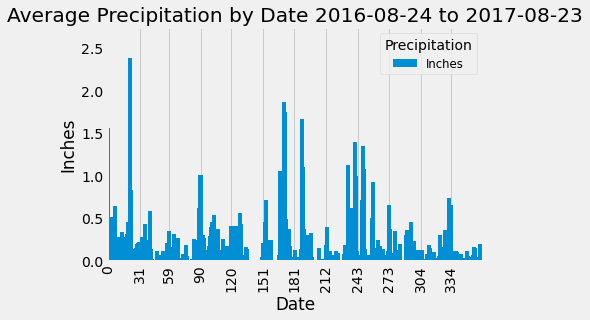

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_clean = precip_data.dropna(how='any')
precip_grp = precip_clean.groupby(['date']).mean()
print(precip_grp)

precip_grp.plot.bar(label='Inches', width=4)
plt.title("Average Precipitation by Date 2016-08-24 to 2017-08-23")
plt.xlabel("Date")
plt.ylabel("Inches")
x_axis = np.arange(len(precip_grp))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 90)
plt.legend(loc="best", fontsize='small', title='Precipitation')
plt.xlim(-0.75, len(precip_grp)-.25)
plt.ylim(0, max(precip_grp['prcp']) * 1.15)
plt.grid(axis='y')
plt.show()


# Plot the Results in a Matplotlib bar chart
plt.bar(x_axis, precip_grp['prcp'], align='center', label='Inches', width=4)
plt.title("Average Precipitation by Date 2016-08-24 to 2017-08-23")
plt.xlabel("Date")
plt.ylabel("Inches")
x_axis = np.arange(len(precip_grp))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 90)
plt.legend(loc="best", fontsize='small', title='Precipitation')
plt.xlim(-0.75, len(precip_grp)-.25)
plt.ylim(0, max(precip_grp['prcp']) * 1.15)
plt.grid(axis='y')
plt.show()



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_clean.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(f'There are {station_count} Stations Available.')


There are 9 Stations Available.


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results = session.query(Measurement.station, Measurement.tobs).all()
results2 = session.query(Station.station, Station.name).all()

# Save the query results as a Pandas DataFrame
station_obs = pd.DataFrame(results, columns=['station','tobs'])
station_names = pd.DataFrame(results2, columns=['station','name'])
combined_data = pd.merge(station_obs, station_names, on="station", how="inner")

active_stations = combined_data.groupby(['station','name']).count()
active_stations = active_stations.sort_values(by=['tobs'], ascending=False)
print(active_stations)

                                                    tobs
station     name                                        
USC00519281 WAIHEE 837.5, HI US                     2772
USC00519397 WAIKIKI 717.2, HI US                    2724
USC00513117 KANEOHE 838.1, HI US                    2709
USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US      2669
USC00516128 MANOA LYON ARBO 785.2, HI US            2612
USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US  2202
USC00511918 HONOLULU OBSERVATORY 702.2, HI US       1979
USC00517948 PEARL CITY, HI US                       1372
USC00518838 UPPER WAHIAWA 874.3, HI US               511


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_max = active_stations.index[0][0]
station_name = active_stations.index[0][1]

results = session.query(Measurement.tobs).filter(Measurement.station == station_max).all()
observations = pd.DataFrame(results, columns=['tobs'])

print(f'The most active station is: {station_max} ({station_name})')
print(f"It's lowest recorded temperature is: {observations['tobs'].min()} degrees F")
print(f"It's highest recorded temperature is: {observations['tobs'].max()} degrees F")
print(f"It's average recorded temperature is: {observations['tobs'].mean()} degrees F")

The most active station is: USC00519281 (WAIHEE 837.5, HI US)
It's lowest recorded temperature is: 54.0 degrees F
It's highest recorded temperature is: 85.0 degrees F
It's average recorded temperature is: 71.66378066378067 degrees F


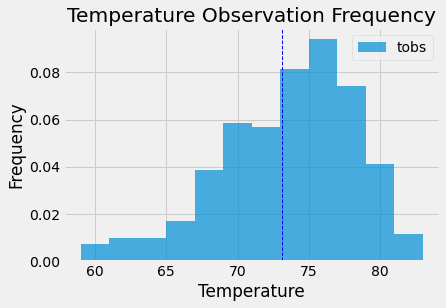

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).filter(Measurement.station == station_max).filter(Measurement.date >= query_date).all()
temp_data = pd.DataFrame(results, columns=['tobs'])
session.close()

# Histogram Plot of Salary Data
plt.title('Temperature Observation Frequency')
plt.hist(temp_data['tobs'], 12, density=True, alpha=0.7, label="tobs")
plt.axvline(temp_data['tobs'].mean(), color='b', linestyle='dashed', linewidth=1)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()  
plt.show()

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [68]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2018-04-20'
date = datetime.strptime(trip_start, "%Y-%m-%d")
trip_end = date + dt.timedelta(days=21)
query_start = date - dt.timedelta(days=365)
query_end = trip_end - dt.timedelta(days=365)
results7 = calc_temps(query_start, query_end)

print(query_start)
print(query_end)
print(results7)

2017-04-20 00:00:00
2017-05-11 00:00:00
[(58.0, 74.03225806451613, 81.0)]


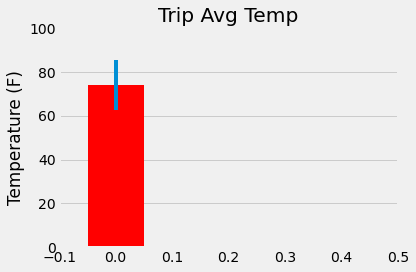

In [69]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = (results7[0][2]-results7[0][0])/2
plt.bar(0, results7[0][1], color='r', width=.1)
plt.errorbar(0, results7[0][1], yerr=error)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.ylim(0, 100)
plt.xlim(-0.1, .5)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [78]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session = Session(engine)
results8 = session.query(Measurement.date, Measurement.station, Measurement.prcp).filter(Measurement.date >= query_start).filter(Measurement.date <= query_end).all()
results9 = session.query(Station.station, Station.name, Station.latitude,Station.longitude,Station.elevation).all()
session.close()
precipitation_data = pd.DataFrame(results8, columns=['date','station','prcp'])
station_data = pd.DataFrame(results9, columns=['station','name','latitude','longitude','elevation'])
combined_stations = pd.merge(precipitation_data, station_data, on="station", how="inner")
station_precipitation = combined_stations.groupby(['station','name']).sum()
station_precipitation = station_precipitation.sort_values(by=['prcp'], ascending=False)
station_precipitation

,,prcp,latitude,longitude,elevation
station,name,,,,
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",10.74,405.37564,-2996.51641,370.5
USC00519281,"WAIHEE 837.5, HI US",8.57,450.48507,-3314.82669,690.9
USC00513117,"KANEOHE 838.1, HI US",8.55,449.89140,-3313.83150,306.6
USC00516128,"MANOA LYON ARBO 785.2, HI US",8.22,426.66200,-3156.05000,3048.0
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",6.06,387.38340,-2841.07320,126.0
USC00519397,"WAIKIKI 717.2, HI US",1.86,425.43200,-3156.33600,60.0
USC00517948,"PEARL CITY, HI US",0.00,106.96700,-789.87550,59.5


In [91]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [95]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
results10 = session.query(Measurement.date).filter(Measurement.date >= query_start).filter(Measurement.date <= query_end).all()
# Stip off the year and save a list of %m-%d strings
all_dates = []
for date in results10:
    date_str = str(date).replace(',','').replace('(','').replace(')','').replace("'",'')
    new_date = datetime.strptime(date_str, "%Y-%m-%d")
    m_d = datetime.strftime(new_date, "%m-%d")
    all_dates.append(m_d)
trip_dates = list(set(all_dates))
trip_dates.sort()
print (trip_dates)        


# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for day in trip_dates:
    norm_tobs = daily_normals(day)
    tobs_tuple = (norm_tobs[0][0],norm_tobs[0][1],norm_tobs[0][2])
    normals.append(tobs_tuple)
session.close()
print(normals)

['04-21', '04-22', '04-23', '04-24', '04-25', '04-26', '04-27', '04-28', '04-29', '04-30', '05-01', '05-02', '05-03', '05-04', '05-05', '05-06', '05-07', '05-08', '05-09', '05-10', '05-11']
[(66.0, 72.32142857142857, 78.0), (65.0, 72.92727272727272, 84.0), (65.0, 73.01818181818182, 79.0), (67.0, 73.3103448275862, 80.0), (66.0, 73.96551724137932, 83.0), (66.0, 74.01724137931035, 81.0), (65.0, 72.87272727272727, 81.0), (63.0, 73.46428571428571, 79.0), (66.0, 73.30357142857143, 81.0), (58.0, 71.5576923076923, 78.0), (65.0, 72.75925925925925, 79.0), (65.0, 73.05084745762711, 79.0), (67.0, 73.41071428571429, 84.0), (65.0, 73.59649122807018, 78.0), (67.0, 73.39655172413794, 79.0), (66.0, 73.14035087719299, 80.0), (64.0, 71.78846153846153, 79.0), (65.0, 72.18867924528301, 80.0), (67.0, 72.9322033898305, 79.0), (64.0, 73.3157894736842, 78.0), (65.0, 73.61111111111111, 79.0)]


In [109]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns =['TMin', 'TAvg', 'TMax']) 
df['trip_dates'] = trip_dates
df = df.set_index('trip_dates')
print(df)  

            TMin       TAvg  TMax
trip_dates                       
04-21       66.0  72.321429  78.0
04-22       65.0  72.927273  84.0
04-23       65.0  73.018182  79.0
04-24       67.0  73.310345  80.0
04-25       66.0  73.965517  83.0
04-26       66.0  74.017241  81.0
04-27       65.0  72.872727  81.0
04-28       63.0  73.464286  79.0
04-29       66.0  73.303571  81.0
04-30       58.0  71.557692  78.0
05-01       65.0  72.759259  79.0
05-02       65.0  73.050847  79.0
05-03       67.0  73.410714  84.0
05-04       65.0  73.596491  78.0
05-05       67.0  73.396552  79.0
05-06       66.0  73.140351  80.0
05-07       64.0  71.788462  79.0
05-08       65.0  72.188679  80.0
05-09       67.0  72.932203  79.0
05-10       64.0  73.315789  78.0
05-11       65.0  73.611111  79.0


C:\Users\RobandGrace\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


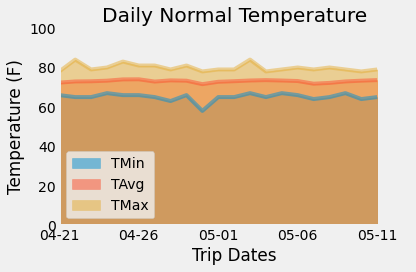

In [117]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False)
plt.title("Daily Normal Temperature")
plt.ylabel("Temperature (F)")
plt.xlabel("Trip Dates")
plt.ylim(0, 100)
plt.xlim(0, len(df)+1)
plt.grid()
plt.tight_layout()
plt.show()